# Propensity score weighing for outcomes in wake-up stroke treatment (ESOC21)

In [169]:
import pandas as pd
from causalinference import CausalModel
import seaborn as sns
import matplotlib.pyplot as plt

In [170]:
from causalinference.estimators.matching import match
data_path = './data/ESOC21/bridg_vs_EVT_HUG_CHUV_ESOC_only CT.xlsx'

## Outcome variables:
any_bleeding infarct_growth	mRS_score_0-1_at_90_days  TICI_2b-3 Symptomatic_intracranial_haemorrhage Parenchymal_haematoma_type_2
NIHSS_score_at_24_h
Change_in_NIHSS_score_from_baseline_to_24_h
8_points_NIHSS_reduction_at_24_h
Change_in_NIHSS_score_from_baseline_to_24_h
mRS_shift_at_90_days
mRS_0-2_at_90_days
Death_at_7_days
Death_at_90_days

In [171]:
outcome_var = 'Parenchymal_haematoma_type_2'

## Covariates

In [172]:
covar_fields = ['Age', 'Sex', 'Time_from_symtoms_recognition_to_groin_min', 'Time_from_LSW_to_groin_min',
                'NIHSS_on_admission',
                'Med_Hist_Hypertension', 'Med Hist Diabetes', 'Med Hist Hyperlipidemia',
                'Med Hist Atrial Fibr', 'Wake-up stroke', 'Hypoperfused tissue volume (Tmax > 6s) ml',
                'Ischemic core volume (CBF < 30%) ml', 'Site of occlusion', 'ASPECTS score (CT or MRI)']

if outcome_var == 'infarct_growth':
    # 9 covariates for infarct growth
    covar_fields = [ 'Time_from_symtoms_recognition_to_groin_min', 'Time_from_LSW_to_groin_min',  'NIHSS_on_admission',
                     'Wake-up stroke',
                     'Hypoperfused tissue volume (Tmax > 6s) ml', 'Ischemic core volume (CBF < 30%) ml',
                     'Site of occlusion', 'ASPECTS score (CT or MRI)', 'Age']


## Intervention : IVT with rTPA

In [173]:
intervention_var = 'IVT_with_rtPA'

In [174]:

data = pd.read_excel(data_path)

data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(' ','_')
covar_fields = [covar.replace(' ','_') for covar in covar_fields]

# Encode mRS as int
data['mRS_score_0-1_at_90_days'] = data['mRS_score_0-1_at_90_days'].astype('Int64')

# Encode wake-up
data['Wake-up_stroke'] = data['Wake-up_stroke'].astype('int')

# Encode infarct growth
data['infarct_growth'] = data['Lesion_volume_(ml)'] - data['Ischemic_core_volume_(CBF_<_30%)_ml']
data.loc[data['infarct_growth'] < 0, 'infarct_growth'] = 0

# Encode change in mRS
data['mRS_shift_at_90_days'] = data['mRS_score_at_90_days'] - data['Pre-stroke_mRS']

# Encode TICI
data['TICI_2b-3'] = data['TICI_2b-3'].astype('int')

# Retain only relevant variables
data = data[covar_fields + [outcome_var, intervention_var]]

In [175]:
# Number treated
n_t = data[intervention_var].sum()

# Number not treated
n_c = data[intervention_var].size - data[intervention_var].sum()
print('Before dropping NA', n_t, n_c)

Before dropping NA 28 55


In [176]:
# Number of events in treatment group
n_events_t = data[data[intervention_var] == 1][outcome_var].sum()
print('Before dropping NA', n_events_t, n_events_t/n_t)

# Number of events in control group
n_events_c =data[data[intervention_var] == 0][outcome_var].sum()
print('Before dropping NA', n_events_c, n_events_c/n_c)

Before dropping NA 4.0 0.14285714285714285
Before dropping NA 5.0 0.09090909090909091


In [177]:
# median and IQR of events in treatment group
print(data[data[intervention_var] == 1][outcome_var].median())
data[data[intervention_var] == 1][outcome_var].quantile(0.25), data[data[intervention_var] == 1][outcome_var].quantile(0.75)

0.0


(0.0, 0.0)

In [178]:
# median and IQR of events in control group
print(data[data[intervention_var] == 0][outcome_var].median())
data[data[intervention_var] == 0][outcome_var].quantile(0.25), data[data[intervention_var] == 0][outcome_var].quantile(0.75)


0.0


(0.0, 0.0)

In [179]:
# Drop NaN (has to be done before one-hot-encoding)
data = data.dropna()

In [180]:
# Clean localisation column
if 'Site_of_occlusion' in data.columns:
    data['Site_of_occlusion'] = data['Site_of_occlusion'].str.replace('ICA','ACI')
    data['Site_of_occlusion'] = data['Site_of_occlusion'].str.replace('et','+')

# One-hot encoding for categorical vars
if 'Sex' in data.columns: data['Sex'] = data['Sex'] == 1
if 'Site_of_occlusion' in data.columns:
    data['Site_of_occlusion'] = pd.Categorical(data['Site_of_occlusion'])
    data['Site_of_occlusion'] = data['Site_of_occlusion'].cat.codes

data = data.astype(float)


In [181]:
# Number treated
n_t = data[intervention_var].sum()
# Number not treated
n_c = data[intervention_var].size - data[intervention_var].sum()
print('After dropping NA', n_t, n_c)

After dropping NA 24.0 46.0


In [182]:
# Number of events in treatment group
n_events_t = data[data[intervention_var] == 1][outcome_var].sum()
print('After dropping NA', n_events_t, n_events_t/n_t)

# Number of events in control group
n_events_c =data[data[intervention_var] == 0][outcome_var].sum()
print('After dropping NA', n_events_c, n_events_c/n_c)

After dropping NA 4.0 0.16666666666666666
After dropping NA 5.0 0.10869565217391304


In [183]:
# median and IQR of events in treatment group
print(data[data[intervention_var] == 1][outcome_var].median())
data[data[intervention_var] == 1][outcome_var].quantile(0.25), data[data[intervention_var] == 1][outcome_var].quantile(0.75)

0.0


(0.0, 0.0)

In [184]:
# median and IQR of events in control group
print(data[data[intervention_var] == 0][outcome_var].median())
data[data[intervention_var] == 0][outcome_var].quantile(0.25), data[data[intervention_var] == 0][outcome_var].quantile(0.75)


0.0


(0.0, 0.0)

Defining model with regards to IVT as intervention

In [185]:
intervention = data.IVT_with_rtPA.to_numpy()
outcome = data[outcome_var].to_numpy()

covars = data[covar_fields].to_numpy()

In [186]:
causal = CausalModel(outcome, intervention, covars)
print(causal.summary_stats)


Summary Statistics

                        Controls (N_c=46)          Treated (N_t=24)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y        0.109        0.315        0.167        0.381        0.058

                        Controls (N_c=46)          Treated (N_t=24)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       67.339       18.565       72.172       12.573        0.305
             X1        0.522        0.505        0.458        0.509       -0.125
             X2      202.152       49.051      237.917       96.888        0.466
             X3      682.674      325.241      715.250      351.885        0.096
             X4       16.022        6.094       15.458        6.427       -0.090
      

Estimate propensity scores

In [187]:
causal.est_propensity()
print(causal.propensity)
print(causal.propensity.keys())


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -3.773      3.507     -1.076      0.282    -10.647      3.101
            X0      0.004      0.025      0.158      0.875     -0.044      0.052
            X1     -0.606      0.652     -0.929      0.353     -1.883      0.672
            X2      0.005      0.006      0.863      0.388     -0.007      0.018
            X3      0.001      0.001      0.646      0.518     -0.001      0.003
            X4     -0.113      0.073     -1.544      0.123     -0.257      0.031
            X5      0.145      0.858      0.169      0.866     -1.537      1.827
            X6      1.125      0.904      1.245      0.213     -0.647      2.898
            X7     -1.196      0.735     -1.627      0.104     -2.637      0.245
            X8      0.808      0.818      0.988      0.323     -0.

Match by nearest neighbour defined as distance between the covariate vectors

In [188]:
# causal.est_via_matching(bias_adj=True)
# print(f'Outcome variable: {outcome_var}')
# print(causal.estimates)


Match by blocks of propensity scores

In [189]:
# causal.stratify_s()
# print(causal.strata)
# causal.est_via_blocking()
# print(f'Outcome variable: {outcome_var}')
# print(causal.estimates)


Match through log regression of covariates and propensity score (Horvitz-Thompson weighting estimator)

In [190]:
causal.est_via_weighting()
print(f'Outcome variable: {outcome_var}')
print(causal.estimates)

Outcome variable: Parenchymal_haematoma_type_2

Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.080      0.067      1.210      0.226     -0.050      0.211



/Users/jk1/opt/anaconda3/envs/uw_bridging/lib/python3.8/site-packages/causalinference/estimators/weighting.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  wlscoef = np.linalg.lstsq(Z_w, Y_w)[0]


In [191]:
data['propensity_score'] = causal.propensity['fitted']

## Distribution of covariates with respect to treatment and outcome

[]

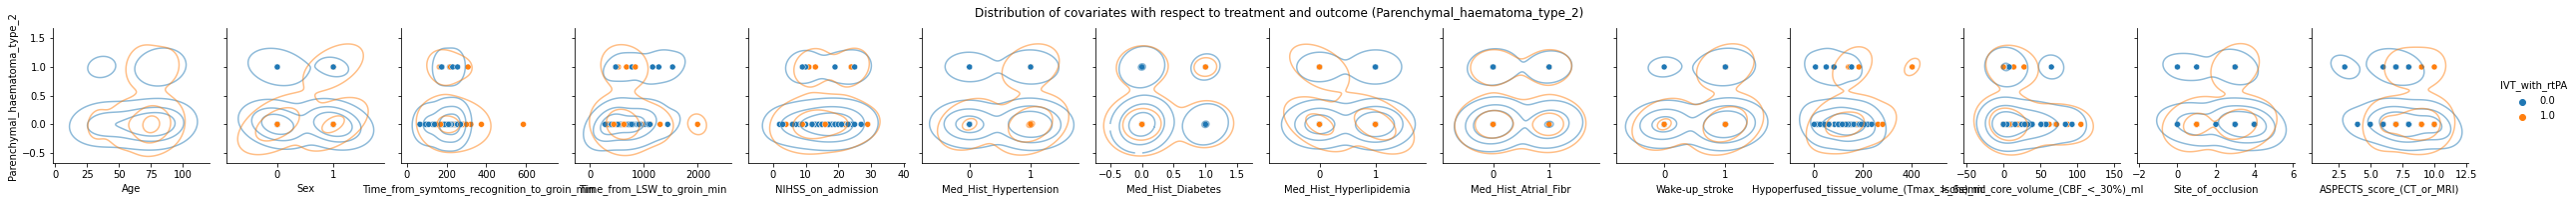

In [192]:
g = sns.pairplot(
    data,
    x_vars=covar_fields,
    y_vars=[outcome_var],
    hue=intervention_var,
    kind='scatter',
)
g.map(sns.kdeplot, alpha=.5, levels=4)

g.fig.suptitle(f'Distribution of covariates with respect to treatment and outcome ({outcome_var})', y=1.08)

plt.plot()

In [193]:
g.savefig(f'{outcome_var}_covariates_distribution.png')

In [194]:
# sns.stripplot(x=outcome_var, y="propensity_score", hue='IVT_with_rtPA', data=data)
#

In [195]:
# sns.stripplot(x="index", y="propensity_score", hue='IVT_with_rtPA', data=data.reset_index())



In [196]:
# sns.displot(data.reset_index(), x="propensity_score", hue='IVT_with_rtPA', kind="kde")


